In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/clue"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/clue


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Other constants
DATASET_DIR = "./"
DATA_FILENAME = "dataset.csv"

dataframe = pd.read_csv(f"{DATASET_DIR}{DATA_FILENAME}")
dataframe.sample(5)

,GAME_ID,G_home,W_home,L_home,W_PCT_home,HOME_RECORD_home,ROAD_RECORD_home,G_prev_home,W_prev_home,L_prev_home,W_PCT_prev_home,HOME_RECORD_prev_home,ROAD_RECORD_prev_home,G_away,W_away,L_away,W_PCT_away,HOME_RECORD_away,ROAD_RECORD_away,G_prev_away,W_prev_away,L_prev_away,W_PCT_prev_away,HOME_RECORD_prev_away,ROAD_RECORD_prev_away,WIN_PRCT_home_3g,PTS_home_3g,FG_PCT_home_3g,FT_PCT_home_3g,FG3_PCT_home_3g,AST_home_3g,REB_home_3g,WIN_PRCT_away_3g,PTS_away_3g,FG_PCT_away_3g,FT_PCT_away_3g,FG3_PCT_away_3g,AST_away_3g,REB_away_3g,SEASON,HOME_TEAM_WINS
7240,21200349,22,10,12,0.455,0.600000,0.333333,66,28,38,0.424,0.606061,0.242424,22,5,17,0.227,0.230769,0.222222,66,21,45,0.318,0.333333,0.303030,0.666667,90.000000,0.415333,0.868000,0.213333,17.000000,45.000000,0.000000,86.666667,0.420333,0.716333,0.372333,20.000000,42.333333,2012,1
17063,12000031,2,0,2,0.000,NaN,0.000000,73,34,39,0.466,0.435897,0.500000,2,2,0,1.000,1.000000,NaN,71,52,19,0.732,0.714286,0.750000,0.333333,108.333333,0.468000,0.746333,0.347667,24.000000,43.333333,1.000000,108.000000,0.469333,0.706667,0.450667,22.000000,45.666667,2020,0
2547,20800915,59,37,22,0.627,0.700000,0.551724,82,56,26,0.683,0.731707,0.634146,61,37,24,0.607,0.741935,0.466667,82,51,31,0.622,0.829268,0.414634,1.000000,97.333333,0.438000,0.769667,0.367000,21.333333,49.333333,0.666667,101.000000,0.467333,0.859667,0.356667,23.333333,42.000000,2008,1
3019,20900072,4,2,2,0.500,1.000000,0.000000,82,35,47,0.427,0.560976,0.292683,5,4,1,0.800,1.000000,0.666667,82,47,35,0.573,0.756098,0.390244,0.666667,86.666667,0.376667,0.804333,0.232000,16.333333,46.333333,0.666667,106.666667,0.484333,0.830667,0.337333,19.666667,44.333333,2009,1
17276,21900498,33,21,12,0.636,0.823529,0.437500,82,48,34,0.585,0.707317,0.463415,35,23,12,0.657,0.888889,0.411765,82,51,31,0.622,0.756098,0.487805,0.333333,110.000000,0.450333,0.776667,0.365000,26.000000,41.666667,0.333333,111.333333,0.436667,0.789667,0.385000,25.333333,47.000000,2019,1


40 2 ['NO', 'YES']


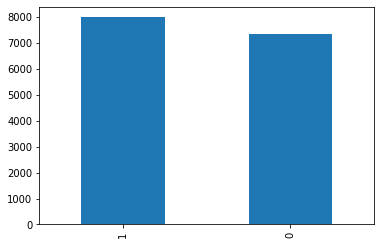

In [8]:
TARGET="HOME_TEAM_WINS"
input_size=len(dataframe.columns)-1
classes  = ["NO", "YES"]
output_size=len(classes)
print(input_size,  output_size,  classes)

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [9]:
# Remove rows with nan values
initial_len =  len(dataframe)
dataframe.dropna(inplace=True)
print(f"{len(dataframe)}/{initial_len}")

dataframe.info()

14330/15345
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14330 entries, 0 to 17920
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GAME_ID                14330 non-null  int64  
 1   G_home                 14330 non-null  int64  
 2   W_home                 14330 non-null  int64  
 3   L_home                 14330 non-null  int64  
 4   W_PCT_home             14330 non-null  float64
 5   HOME_RECORD_home       14330 non-null  float64
 6   ROAD_RECORD_home       14330 non-null  float64
 7   G_prev_home            14330 non-null  int64  
 8   W_prev_home            14330 non-null  int64  
 9   L_prev_home            14330 non-null  int64  
 10  W_PCT_prev_home        14330 non-null  float64
 11  HOME_RECORD_prev_home  14330 non-null  float64
 12  ROAD_RECORD_prev_home  14330 non-null  float64
 13  G_away                 14330 non-null  int64  
 14  W_away                 14330 non-null  int

13814/15345


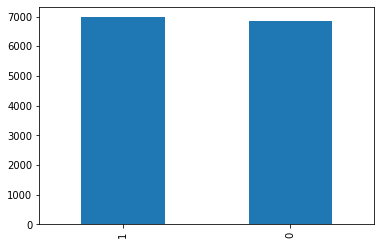

In [10]:
# Balance data

min_count = min(target.values)
max_count  = max(target.values)
remove_n = int((max_count -min_count) * 0.8)
temp = dataframe[dataframe[TARGET]==1]
drop_indices = np.random.choice(temp.index, remove_n, replace=False)

dataframe = dataframe.drop(drop_indices)

num_rows= len(dataframe)
print(f"{num_rows}/{initial_len}")

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [42]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop(TARGET, axis=1).values
targets = dataframe[[TARGET]].values
targets =  np.reshape(targets, len(targets))

inputs.shape, targets.shape

((13814, 40), (13814,))

In [73]:
# metrics and validations techniques
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support


# classifiers from sklearn example
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid

from time import time, gmtime


In [71]:
IMAGES_PATH=  "./"
def benchmark_report(clf, x_train, y_train, x_test, y_test, target_names=None, features_name=None):
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0

    t0 = time()
    pred = clf.predict(x_test)
    pred_proba = clf.predict_proba(x_test)
    test_time = time() - t0

    score = metrics.accuracy_score(y_test, pred)
    rept = precision_recall_fscore_support(y_test, pred, average='weighted')

    return (rept[0], rept[1], rept[2], train_time, test_time), pred_proba     # is returning  presicion, recall, f1 score, and training and test times

def plot_classifier_comparison(clfs_dict, experiment_name=None):
    clf_names = clfs_dict.keys()
    indices = np.arange(len(clf_names))
    pres, rec, f1, train_time, test_time = [
        [clfs_dict[k]['results']['mean'][i] for k in clf_names] for i in range(5)]

    train_time = np.array(train_time) / np.max(train_time)
    test_time = np.array(test_time) / np.max(test_time)
    
    comp_figure = plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.grid()

    plt.title("Classifiers Comparison Metrics")
    plt.barh(indices, pres, .1, label="precision", color='blue')
    plt.barh(indices+.1, rec, .1, label="recall", color='red')
    plt.barh(indices+.2, f1, .1, label="f1", color='green')

    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.subplot(1, 2, 2)
    plt.grid()

    plt.title("Classifiers Comparison Times")

    plt.barh(indices+.3, train_time, .1, label="training time",color='orange')
    plt.barh(indices+.4, test_time, .1, label="test time (batch)", color='darkorange')
    
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    plt.tight_layout()
    a = gmtime(time())
    date = str.format('{0}{1}{2}', a.tm_year, a.tm_mon, a.tm_mday)
    name = str.format('{0}{1} {2}.png',IMAGES_PATH, date, experiment_name if experiment_name else 'classifier_comparison')
    plt.savefig(name)
    plt.show()

def resume_report(kfold_metrics, verbose=True):
    means = np.mean(kfold_metrics, axis=0)
    stds = np.std(kfold_metrics, axis=0)
    resume = {'mean': means, 'std': stds }
    if verbose:
        print('_' * 80)
        print("train time: %0.3fs , %0.3fs" % (means[3], stds[3]) )
        print("test time:  %0.3fs, %0.3fs" % (means[4], stds[4]))
        print("precision:   %0.3f, %0.3fs" % (means[0], stds[0]))
        print("recall:   %0.3f, %0.3fs" % (means[1], stds[1]))
        print("fbeta_score:   %0.3f, %0.3fs" % (means[2], stds[2]))
    return resume

In [66]:
def classifier_comparison(clf_dict, X=None, Y=None, k_fold_splits=3, plot=True, verbose=True, tag=None):
    '''
    
    '''
    kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=42)

    for i, name in enumerate(clf_dict.keys()):
        clf = clf_dict[name]['f']
        if verbose:
            print('=' * 80)
            print(name)
            print(clf)
            print('_' * 80)

        clf_dict[name]['results'] = []
        clf_dict[name]['predicts_proba'] = []
        
        for i, (train, test) in enumerate(kf.split(X, Y)):

            X_train = X[train]
            y_train = Y[train]
            X_test =  X[test]
            y_test = Y[test]

            if verbose:
                print(str.format(f'---> kfold {i}: train_samples: {X_train.shape[0]}, test_samples:{X_test.shape[0]},  n_features: {X_train.shape[1]}'))
            
            benchmark, predict_proba  = benchmark_report(clf, X_train, y_train, X_test, y_test)
            
            clf_dict[name]['results'].append(list(benchmark))
            clf_dict[name]['predicts_proba'].append(predict_proba)

        clf_dict[name]['results'] = resume_report(clf_dict[name]['results'], verbose=verbose)
    return  clf_dict

    

In [67]:
clfs = {
    "Naive Bayes - Bernoulli":{
         'f' : BernoulliNB()},
    
    "Nearest Neighbors" :{
         'f' : KNeighborsClassifier(3)} ,
    
    "Decision Tree":{
         'f' : DecisionTreeClassifier(max_depth=5)},
    
    "Random Forest":{ 
         'f' : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)},
    
    "Neural Net":{ 
         'f' :MLPClassifier(alpha=1) },
    
    "AdaBoost":{ 
         'f' :  AdaBoostClassifier()},
    
    "Stratified Gradient Descent - log":{ 
         'f' : SGDClassifier(loss='log', penalty='elasticnet')},

    "Stratified Gradient Descent - modified_huber":{ 
         'f' : SGDClassifier(loss='modified_huber', penalty='l1')},
}

In [68]:
resume_dict=  classifier_comparison(clfs, X=inputs, Y=targets, verbose=True, tag="Test1")


Naive Bayes - Bernoulli
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
________________________________________________________________________________
---> kfold 0: train_samples: 9209, test_samples:4605,  n_features: 40
---> kfold 1: train_samples: 9209, test_samples:4605,  n_features: 40
---> kfold 2: train_samples: 9210, test_samples:4604,  n_features: 40
________________________________________________________________________________
train time: 0.011s , 0.001s
test time:  0.005s, 0.000s
precision:   0.575, 0.006s
recall:   0.550, 0.002s
fbeta_score:   0.502, 0.002s
Nearest Neighbors
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
________________________________________________________________________________
---> kfold 0: train_samples: 9209, test_samples:4605,  n_features: 40
---> kfold 1: train_samples: 9209, test_sa

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 1: train_samples: 9209, test_samples:4605,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 2: train_samples: 9210, test_samples:4604,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________________________________________________________________________
train time: 11.270s , 0.088s
test time:  0.010s, 0.002s
precision:   0.253, 0.005s
recall:   0.503, 0.005s
fbeta_score:   0.336, 0.005s
AdaBoost
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
________________________________________________________________________________
---> kfold 0: train_samples: 9209, test_samples:4605,  n_features: 40
---> kfold 1: train_samples: 9209, test_samples:4605,  n_features: 40
---> kfold 2: train_samples: 9210, test_samples:4604,  n_features: 40
________________________________________________________________________________
train time: 1.235s , 0.014s
test time:  0.108s, 0.002s
precision:   0.643, 0.008s
recall:   0.643, 0.008s
fbeta_score:   0.643, 0.008s
Stratified Gradient Descent - log
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 1: train_samples: 9209, test_samples:4605,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 2: train_samples: 9210, test_samples:4604,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


________________________________________________________________________________
train time: 0.666s , 0.059s
test time:  0.001s, 0.000s
precision:   0.253, 0.005s
recall:   0.503, 0.005s
fbeta_score:   0.336, 0.005s
Stratified Gradient Descent - modified_huber
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
________________________________________________________________________________
---> kfold 0: train_samples: 9209, test_samples:4605,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 1: train_samples: 9209, test_samples:4605,  n_features: 40


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---> kfold 2: train_samples: 9210, test_samples:4604,  n_features: 40
________________________________________________________________________________
train time: 0.703s , 0.032s
test time:  0.002s, 0.000s
precision:   0.250, 0.005s
recall:   0.500, 0.005s
fbeta_score:   0.333, 0.006s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
resume_dict["AdaBoost"]

{'f': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=None),
 'predicts_proba': [array([[0.50403635, 0.49596365],
         [0.49774765, 0.50225235],
         [0.49844997, 0.50155003],
         ...,
         [0.5081214 , 0.4918786 ],
         [0.5073601 , 0.4926399 ],
         [0.51055526, 0.48944474]]), array([[0.50174847, 0.49825153],
         [0.50112946, 0.49887054],
         [0.49570547, 0.50429453],
         ...,
         [0.497373  , 0.502627  ],
         [0.49798304, 0.50201696],
         [0.49963645, 0.50036355]]), array([[0.49572468, 0.50427532],
         [0.49591038, 0.50408962],
         [0.49028878, 0.50971122],
         ...,
         [0.49925816, 0.50074184],
         [0.50121896, 0.49878104],
         [0.50277903, 0.49722097]])],
 'results': {'mean': array([0.64348393, 0.64347748, 0.64340837, 1.23473771, 0.10762183]),
  'std': array([0.00775279, 0.00776458, 0.0077582 , 0.0137303 , 0.00231517

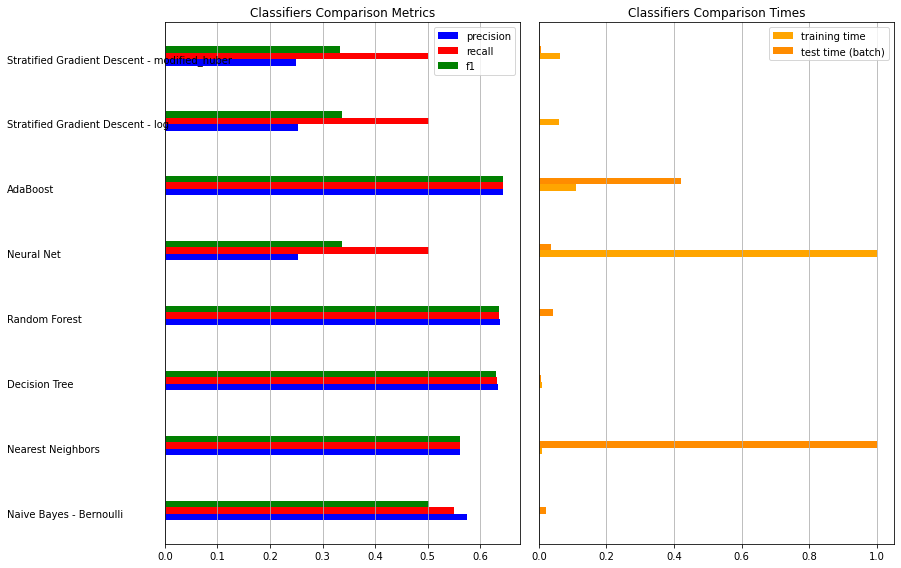

In [74]:
plot_classifier_comparison(resume_dict, experiment_name="Test1")

In [77]:
val_percent = .15 
val_size = int(len(inputs) * val_percent)
train_size = num_rows - val_size

In [81]:
clf = clfs['Decision Tree']['f']
x_train = inputs[0:train_size]
y_train = targets[0:train_size]

x_test = inputs[train_size:len(inputs)]
y_test = targets[train_size:len(inputs)]

benchmark, predict_proba = benchmark_report(clf, x_train, y_train, x_test, y_test)
resume_report([benchmark], verbose=True)

________________________________________________________________________________
train time: 0.128s , 0.000s
test time:  0.001s, 0.000s
precision:   0.621, 0.000s
recall:   0.621, 0.000s
fbeta_score:   0.621, 0.000s


{'mean': array([0.62099254, 0.621139  , 0.62104132, 0.12783098, 0.0011282 ]),
 'std': array([0., 0., 0., 0., 0.])}

In [84]:
def predict_single(input, label):
  prediction =  clf.predict([input])
  print(f"label: {label}")
  print(f"prediction: {prediction}")

In [2]:
index=100
target = targets[index]
input = inputs[index]
predict_single(input,target)

NameError: name 'targets' is not defined

In [96]:
import joblib
# now you can save it to a file
joblib.dump(clf, 'nba_sklearn_model.pkl') 

# and later you can load it
clf = joblib.load('nba_sklearn_model.pkl')